In [18]:
! load_ext autoreload
! autoreload 2
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
import os
import math
import re
from itertools import groupby
from typing import Callable, Dict, List, Optional, Set, Tuple, Type, Union

import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('../')
from lora_diffusion import LoraInjectedConv2d, LoraInjectedLinear, patch_pipe, tune_lora_scale, parse_safeloras
from lora_diffusion.lora import _find_modules, UNET_CROSSATTN_TARGET_REPLACE, DEFAULT_TARGET_REPLACE
from reg_lora.visual import visualize_images
import safetensors

# os.environ["DISABLE_TELEMETRY"] = 'YES'
model_id = "runwayml/stable-diffusion-v1-5"
device = torch.device("cuda:3")
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16,local_ckpt_files_only=True,revision='39593d5650112b4cc580433f6b0435385882d819').to(device)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
torch.manual_seed(0)


zsh:1: command not found: load_ext
zsh:1: command not found: autoreload


Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 145299.21it/s]
Keyword arguments {'local_ckpt_files_only': True} are not expected by StableDiffusionPipeline and will be ignored.


### 在attn_layer中插入hook函数, 可视化attn_map 

In [17]:
%%capture
import os
path = 'output/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e37_s6000.safetensors'
path = 'output/output_dog_Ti-clip_norm_3e-5/lora_weight_e37_s6000.safetensors'
prompt = "a <krk1> dog in grand canyon" 
command = f'python vis_attn_map.py --lora_path {path} --prompt {prompt} --gpu 0 --name up_blocks.2.attentions.1.transformer_blocks.0.attn2'
os.system(command)

sh: 1: cannot open krk1: No such file


### 计算TI后cpation-image的Clip score

In [26]:
import re
import os
import copy
import torch

from PIL import Image
from transformers import CLIPProcessor, CLIPModel

lora_dir = '../output/output_dog_Ti-clip_Nonorm_3e-5'
root_img_path = '/home/zhicai/poseVideo/lora-master/dataset/data/dog'
ckpt_pattern = r'lora_weight_e\d+_s\d{3,4}.safetensors'
captions = ["photo of a <krk1> dog", "photo of a dog"]
device = 'cuda:3'
weight_dtype = torch.float32


model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device,dtype = weight_dtype)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

images = [Image.open(os.path.join(root_img_path, img_path)) for img_path in os.listdir(root_img_path)]
    
_ckpt_files = os.listdir(lora_dir)
ckpt_files = [f for f in _ckpt_files if re.match(ckpt_pattern, f)]

probs_list = []
for _file in sorted(ckpt_files,
                    key = lambda x: int(re.match(r'.*e([0-9]+).*', x.split('/')[-1])[1]), 
                    reverse=False):
    
    lora_path = os.path.join(lora_dir, _file)
    print(f"loading from: {lora_path}")
    patch_pipe( 
        pipe,
        lora_path,
        patch_text=False,
        patch_ti=True,
        patch_unet=True,
        filter_crossattn_str = 'cross+self'
    )

    processor.tokenizer = pipe.tokenizer
    model.text_model = copy.deepcopy(pipe.text_encoder.text_model.to(device, dtype=weight_dtype))
    # token_embedding = model.text_model.embeddings.token_embedding
    # token_embedding.weight.data[49408] = token_embedding.weight.data[42170]    
    inputs = processor(text=captions, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    
    image_embeds = outputs.image_embeds
    input_ids = inputs.input_ids
    last_hidden_state = outputs.text_model_output.last_hidden_state
    text_embeds = last_hidden_state[torch.arange(last_hidden_state.size(0), device=input_ids.device),
                                    [(row == 49407).nonzero().min() for row in input_ids]]
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    logit_scale = model.logit_scale.exp()
    logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
    logits_per_image = logits_per_text.t()
    
    probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
    probs_list.append(probs[:,0].mean().item())

loading from: ../output/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e1_s200.safetensors
<krk1>
The tokenizer already contains the token <krk1>.
Replacing <krk1> embedding.
loading from: ../output/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e2_s400.safetensors
<krk1>
The tokenizer already contains the token <krk1>.
Replacing <krk1> embedding.
loading from: ../output/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e3_s600.safetensors
<krk1>
The tokenizer already contains the token <krk1>.
Replacing <krk1> embedding.
loading from: ../output/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e4_s800.safetensors
<krk1>
The tokenizer already contains the token <krk1>.
Replacing <krk1> embedding.
loading from: ../output/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e6_s1000.safetensors
<krk1>
The tokenizer already contains the token <krk1>.
Replacing <krk1> embedding.
loading from: ../output/output_dog_Ti-clip_Nonorm_3e-5/lora_weight_e7_s1200.safetensors
<krk1>
The tokenizer already contains the token <krk1>.


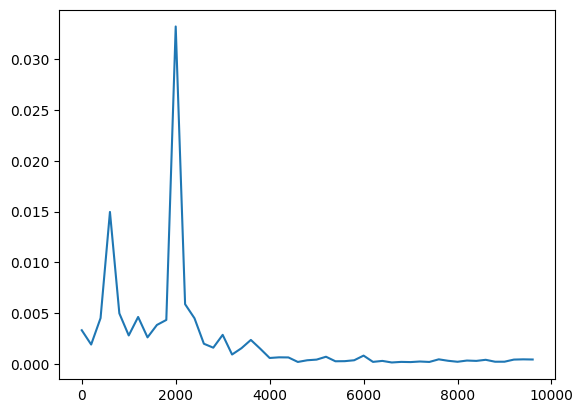

In [27]:
import matplotlib.pyplot as plt 
plt.plot(np.arange(len(probs_list)) * 200, probs_list)
plt.show()

### 统计Lora中的self和cross attn模块中的Linear-layer权重漂移和对文本映射后的语义漂移

In [ ]:
target_dir = '../output_dog'
test_prompts = ['a dog','a cat','a teddybear','a chair']
reg_prompt = ['photo of a dog']

lora_weight_norm_list_cross = []
lora_weight_norm_list_self = []
lora_context_reg_resides_list = []

# 找到cross_attn 和 self_attn的位置
cnt = 0
cross_idxs = []
self_idxs = []
for target, name, module in _find_modules(pipe.unet, DEFAULT_TARGET_REPLACE):
    if module.in_features == 768:
        cross_idxs.append(cnt)
    if module.in_features != 320 and (name == 'to_k' or name == 'to_v'):
        self_idxs.append(cnt)
    cnt += 1 

c_reg = pipe._encode_prompt(reg_prompt,device,1,False)
group = [ckpt_file  for ckpt_file in os.listdir(target_dir) if '_s' in ckpt_file and 'lora_weight' in ckpt_file]
print(group)
sorted_group = sorted(group, key = lambda x: int(re.findall(r'.*s(\d+).*',x)[0]))

for ckpt_file in sorted_group:
        cur_step_list_cross = []
        cur_step_context_reg_reside = []
        cur_step_list_self = []
        ckpt = safetensors.safe_open(os.path.join(target_dir,ckpt_file), framework="pt", device="cpu")
        lora = parse_safeloras(ckpt)  
        for cross_idx , self_idx in zip(cross_idxs,self_idxs):
                up_weight_self = lora['unet'][0][2*self_idx].to(device)
                down_weight_self = lora['unet'][0][2*self_idx+1].to(device)
                up_weight = lora['unet'][0][2*cross_idx].to(device)
                down_weight = lora['unet'][0][2*cross_idx+1].to(device)
                cur_step_lora_project_self = down_weight_self.transpose(0,1) @ up_weight_self.transpose(0,1)
                cur_step_lora_project_cross = down_weight.transpose(0,1) @ up_weight.transpose(0,1)
                cur_step_lora_reside = c_reg @ cur_step_lora_project_cross
                cur_step_context_reg_reside.append(torch.norm(cur_step_lora_reside).cpu().item())
                cur_step_list_cross.append(torch.norm(cur_step_lora_project_cross).cpu().item()) 
                cur_step_list_self.append(torch.norm(cur_step_lora_project_self).cpu().item())
        lora_weight_norm_list_cross.append(np.mean(cur_step_list_cross))
        lora_context_reg_resides_list.append(np.mean(cur_step_context_reg_reside))
        lora_weight_norm_list_self.append(np.mean(cur_step_list_self))

print(lora_weight_norm_list_cross[4:],'\n',lora_weight_norm_list_self[4:],'\n',lora_context_reg_resides_list[4:])

### 
- [0.0, 0.6263046264648438, 0.8959732055664062, 1.081024169921875, 1.23992919921875, 1.386627197265625] 
- [0.0, 0.5961112976074219, 0.9022979736328125, 1.1526870727539062, 1.3598556518554688, 1.5485458374023438] 
- dog: [0.0, 5.158447265625, 7.736480712890625, 9.59881591796875, 11.31317138671875, 13.19952392578125]
- chair: [0.0, 5.53265380859375, 8.1031494140625, 9.82177734375, 11.29705810546875, 12.761962890625]
### PPD+caption
- [0.0, 0.5959930419921875, 0.842529296875, 1.0566635131835938, 1.22564697265625, 1.368316650390625] 
- [0.0, 0.5757675170898438, 0.8561973571777344, 1.0793838500976562, 1.2865676879882812, 1.4570159912109375] 
- dog: [0.0, 5.3741455078125, 7.800537109375, 10.165679931640625, 12.35272216796875, 14.3023681640625]
- cat: [0.0, 5.20684814453125, 7.59259033203125, 9.61798095703125, 11.5421142578125, 13.06976318359375]
- teddybear: [[0.0, 5.019256591796875, 7.05743408203125, 8.72705078125, 10.12554931640625, 11.32147216796875]]
- chiar: [0.0, 5.8436279296875, 8.38720703125, 10.7120361328125, 12.7530517578125, 14.49560546875]
### PPD+prompt
- [0.0, 0.5974349975585938, 0.8715896606445312, 1.1073532104492188, 1.3016281127929688, 1.4680023193359375] 
- [0.0, 0.5708885192871094, 0.8512802124023438, 1.076690673828125, 1.268798828125, 1.4509201049804688] 
- dog: [0.0, 5.468292236328125, 7.7318115234375, 10.11810302734375, 12.46807861328125, 14.0806884765625]
- cat:  [0.0, 4.901824951171875, 7.1387939453125, 8.93017578125, 10.8831787109375, 12.2510986328125]
- teddybear: [0.0, 5.574371337890625, 7.939788818359375, 9.98956298828125, 11.7071533203125, 12.8897705078125]
- chair: [0.0, 4.9346923828125, 7.066162109375, 8.76959228515625, 10.42822265625, 11.67010498046875]